# Project SMS Spam Detection
## CSIS 735	
### By Sandeep Gund

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

import nltk
import string
from nltk.corpus import stopwords


import matplotlib
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import backend as K 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time
#clean up memory
keras.backend.clear_session()

#Use the following random seed for all your experiments
random_seed = 1
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

Using TensorFlow backend.


#### Load the spam.csv file
Clean the unnamed columns.

In [2]:
class AttributesAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, vectorizer): # no *args or **kargs
#         self.vectorizer = vectorizer


    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        self.df_sms = X.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
        self.df_sms = self.df_sms.rename(columns={"v1":"label", "v2":"sms"})
        self.df_sms['sms'] =  self.df_sms['sms'].apply(TextProcess)
        self.df_sms['length'] = self.df_sms['sms'].apply(len)
        self.df_sms['totalwords'] = self.df_sms['sms'].str.count(' ') + 1
        self.df_sms['tokens'] = self.df_sms['sms'].apply(lambda x: nltk.word_tokenize(x))
        self.df_sms['pos_tags'] = self.df_sms['tokens'].apply(lambda x:[t for w, t in nltk.pos_tag(x)])
        self.df_sms['pos_tag_sentence'] = self.df_sms['pos_tags'].apply(lambda x: ' '.join(x))
        le = preprocessing.LabelEncoder()
        self.df_sms['label'] = le.fit_transform(self.df_sms['label'])

        return self.df_sms
    

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [4]:
def TextProcess(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [5]:
def build_SNN_model(n,learning_rate):
    model = Sequential()

    model.add(Dense(1024,activation='tanh',input_dim=n))
    model.add(Dense(512,activation='tanh'))
    model.add(Dense(256,activation='tanh'))
    model.add(Dense(64,activation='tanh'))
    model.add(Dense(32,activation='tanh'))
    model.add(Dense(1,activation='sigmoid'))

    opt = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [6]:
def build_DNN_model(n,learning_rate):
    
    num_classes = 1
    n_hidden1 = 1024
    n_hidden2 = 512
    n_hidden3 = 256
    n_hidden4 = 128
    n_hidden5 = 64
    n_outputs = num_classes
    dropout_rate = 0.1
    num_epochs = 500
    
    hidden_init = keras.initializers.he_normal(seed=1)
    output_init = keras.initializers.glorot_uniform(seed=1) 
    model = Sequential() 

    model.add(Dense(n_hidden1, input_dim=n,kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden2, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden3, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden4, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_hidden5, kernel_initializer=hidden_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('relu'))
    model.add(Dense(n_outputs, kernel_initializer=output_init))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Activation('sigmoid'))


    opt = keras.optimizers.Adagrad(learning_rate=learning_rate)#YOUR CODE GOES HERE#
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


    return model

In [7]:
def predict(X_trainS,X_testS):
    p_train = model.predict(X_trainS)
    h_train = np.array([elem for elem in p_train>0.5], dtype=int)
    p_test = model.predict(X_testS) 
    h_test = np.array([elem for elem in p_test>0.5], dtype=int)  
    return h_train,h_test

In [8]:
def matrix(y_trainCV,h_train):
    cf_train = confusion_matrix(y_trainCV, h_train)
    ca_train = np.mean(accuracy_score(y_trainCV, h_train))
    ps_train = np.mean(precision_score(y_trainCV, h_train, average=None)) 
    rs_train = np.mean(recall_score(y_trainCV, h_train, average=None))
    f1_train = np.mean(f1_score(y_trainCV, h_train, average=None))
    return cf_train,ca_train,ps_train,rs_train,f1_train

In [9]:
#Load Data
spamdataset = pd.read_csv("spam.csv",encoding='latin-1')
spamdataset.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [10]:
#A quick look at the data structure
spamdataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
#A quick description of the data
spamdataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [12]:
num_pipeline = Pipeline(steps = [
                                    ('attribs_adder', AttributesAdder())
                                ])


X_train = num_pipeline.fit_transform(spamdataset)


In [73]:
a=X_train["length"]
print(a.max())

516


Text(0.5, 0, 'Message Length')

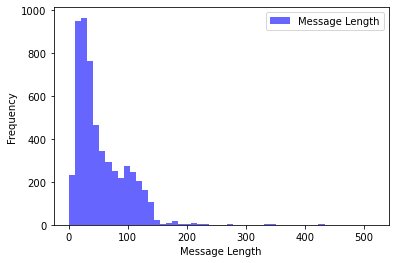

In [14]:
# %matplotlib inline
# X_train['length'].plot(bins=50, kind='hist', color = 'orange',xlabel = 'SMS Length')

# plt.figure()

X_train['length'].plot(bins=50, kind='hist', color='blue', 
                                       label='Message Length', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

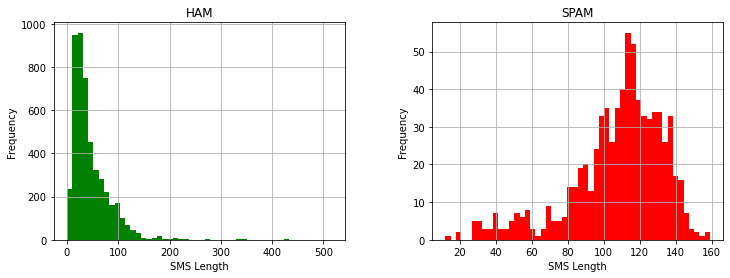

In [15]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

X_train[X_train['label']==0].hist(column='length', bins=50,ax=ax[0],color = 'green')
ax[0].set(xlabel = 'SMS Length',ylabel = 'Frequency',title = 'HAM')
X_train[X_train['label']==1].hist(column='length', bins=50,ax=ax[1],color = 'red')
ax[1].set(xlabel = 'SMS Length',ylabel = 'Frequency',title = 'SPAM');

In [16]:
X = X_train['pos_tag_sentence']
y = X_train['label']
# print(X,y)

In [17]:
X_trainData, X_testData, y_trainS, y_testS = train_test_split(
    X, y, test_size=0.1, random_state=1)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
X_trainS= vectorizer.fit_transform(X_trainData)
X_testS = vectorizer.transform(X_testData)

Now drop the Unnamed column, rename v1 and v2 as label and sms

In [19]:
print(X_trainS.shape, y_trainS.shape, X_testS.shape, y_testS.shape)

(5014, 26) (5014,) (558, 26) (558,)


In [20]:
# frequency_matrix = pd.DataFrame(training_data, columns = training_data.get_feature_names())
# frequency_matrix

In [21]:
X_testS.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.39667208, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.84456818, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
model_SGDClassifier = SGDClassifier(eta0=0.1, max_iter=1000, tol=0.1, random_state=1, loss='log')#, penalty="l2")
model_SGDClassifier.fit(X_trainS, y_trainS.squeeze())

SGDClassifier(eta0=0.1, loss='log', random_state=1, tol=0.1)

In [23]:
h_train = model_SGDClassifier.predict(X_trainS)
# h_val = model_SGDClassifier.predict(validation_data)
h_test = model_SGDClassifier.predict(X_testS)
print("Prediction: ",h_train)


Prediction:  [0 0 0 ... 0 0 0]


In [24]:
pred_scores = []

##Validation matirx
cf_train = confusion_matrix(y_trainS,h_train)
ca_train = accuracy_score(np.squeeze(y_trainS),h_train)
ps_train = precision_score(y_trainS,h_train)
rs_train = recall_score(y_trainS,h_train)
f1_train = f1_score(y_trainS,h_train)
print(">>>>>>>>>>Training Performance<<<<<<<<<<")
print("Train Confusion Matrix:\n", cf_train)
print("Train Accuracy: {0:0.2%}".format(ca_train))
print("Train Precision {0:0.2%}".format(ps_train))
print("Train Recall: {0:0.2%}".format(rs_train))
print("Train F1: {0:0.2%}".format(f1_train))


>>>>>>>>>>Training Performance<<<<<<<<<<
Train Confusion Matrix:
 [[4129  206]
 [ 206  473]]
Train Accuracy: 91.78%
Train Precision 69.66%
Train Recall: 69.66%
Train F1: 69.66%


In [25]:
##Testing matirx
cf_train = confusion_matrix(y_trainS,h_train)
ca_train = accuracy_score(np.squeeze(y_trainS),h_train)
ps_train = precision_score(y_trainS,h_train)
rs_train = recall_score(y_trainS,h_train)
f1_train = f1_score(y_trainS,h_train)
print(">>>>>>>>>>Training Performance<<<<<<<<<<")
print("Train Confusion Matrix:\n", cf_train)
print("Train Accuracy: {0:0.2%}".format(ca_train))
print("Train Precision {0:0.2%}".format(ps_train))
print("Train Recall: {0:0.2%}".format(rs_train))
print("Train F1: {0:0.2%}".format(f1_train))

# print("Y_test:",np.squeeze(y_test))
# print("h_test:", h_test)

cf_test = confusion_matrix(y_testS,h_test)
ca_test = accuracy_score(np.squeeze(y_testS),h_test)
ps_test = precision_score(y_testS,h_test)
rs_test = recall_score(y_testS,h_test)
f1_test = f1_score(y_testS,h_test)
print("\n>>>>>>>>>>Test Performance<<<<<<<<<<")
print("Test Confusion Matrix:\n", cf_test)
print("Test Accuracy: {0:0.2%}".format(ca_test))
print("Test Precision {0:0.2%}".format(ps_test))
print("Test Recall {0:0.2%}".format(rs_test))
print("Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SGDClassifier_TfidfVectorizer",f1_test))


>>>>>>>>>>Training Performance<<<<<<<<<<
Train Confusion Matrix:
 [[4129  206]
 [ 206  473]]
Train Accuracy: 91.78%
Train Precision 69.66%
Train Recall: 69.66%
Train F1: 69.66%

>>>>>>>>>>Test Performance<<<<<<<<<<
Test Confusion Matrix:
 [[462  28]
 [ 16  52]]
Test Accuracy: 92.11%
Test Precision 65.00%
Test Recall 76.47%
Test F1: 70.27%


In [26]:
#model = SGDClassifier(learning_rate='invscaling', eta0=0.01, max_iter=1000, tol=0.1, random_state=1, loss='log')
model = SGDClassifier(eta0=0.3, max_iter=1000, tol=0.1, random_state=1, loss='log', penalty="l2")
f1_scores = cross_val_score(model, X_trainS, y_trainS.squeeze(), scoring='f1', cv=10 )
print("CV F1 scores: ", f1_scores)
print("Average F1: {0:0.2%}".format(np.mean(f1_scores)))

CV F1 scores:  [0.68493151 0.68085106 0.66197183 0.67741935 0.57627119 0.58928571
 0.6984127  0.6875     0.68531469 0.6962963 ]
Average F1: 66.38%


In [27]:


start = time.time()

model = SGDClassifier(tol=0.1, random_state=1, loss='log')
param_grid = [
                {'learning_rate': ['invscaling', 'adaptive'],
                 'eta0': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                 'max_iter': [1000, 2000, 3000, 4000, 5000], 
                }
]

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', refit=True)
grid_search.fit(X_trainS, y_trainS.squeeze())
print(grid_search.best_params_)
# grid_search.best_params_ :{'eta0': 0.3, 'learning_rate': 'adaptive', 'max_iter': 100}

print(f'Time: {time.time() - start}')

{'eta0': 0.9, 'learning_rate': 'adaptive', 'max_iter': 1000}
Time: 12.403430700302124


In [28]:
best_model = grid_search.best_estimator_


h_train = model_SGDClassifier.predict(X_trainS)
h_test = best_model.predict(X_testS)

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)


ca = accuracy_score(np.squeeze(y_testS), h_test)
cf = confusion_matrix(y_testS, h_test)
ps = precision_score(y_testS, h_test) 
rs = recall_score(y_testS, h_test)
f1 = f1_score(y_testS, h_test)

print(">>>>>>>>>> Test Performance <<<<<<<<<")
print("Accuracy: {0:0.2%}".format(ca))
print("Confusion Matrix:\n", cf)
print("Precision: {0:0.2%}".format(ps))
print("Recall:    {0:0.2%}".format(rs))
print("F1:        {0:0.2%}".format(f1))

pred_scores.append(("SGDClassifier_GS_TfidfVectorizer",f1))

>>>>>>>>>> Test Performance <<<<<<<<<
Accuracy: 92.29%
Confusion Matrix:
 [[468  22]
 [ 21  47]]
Precision: 68.12%
Recall:    69.12%
F1:        68.61%


Input: Develop a Shallow Neural Network (SNN) 

In [29]:
# X_trainS, X_testS, y_trainS, y_testS = train_test_split(X, 
#                                                     y,test_size=0.10, shuffle=True,
#                                                     random_state=1)

In [30]:
# vectorizer =TfidfVectorizer(sublinear_tf=True, max_df=0.5,
#                                  stop_words='english')
# X_trainS= vectorizer.fit_transform(X_trainData)
# # X_testS = vectorizer.transform(X_testData)

In [31]:
print(X_trainS.shape, y_trainS.shape, X_testS.shape, y_testS.shape)

(5014, 26) (5014,) (558, 26) (558,)


In [32]:
K.clear_session()

start = time.time()


num_epochs=50

early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_SNN_model(X_trainS.shape[1],0.1)
history = model.fit(X_trainS,
                   y_trainS,
                   epochs=num_epochs,
                   verbose=0,
                   validation_split=0.1,
                   callbacks=callbacks_list)
history_dict = history.history
history_dict.keys()

print(f'Time: {time.time() - start}')

Time: 12.122161626815796


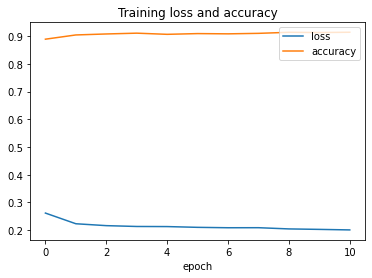

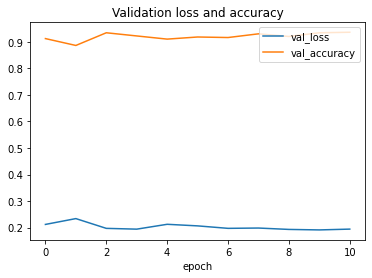

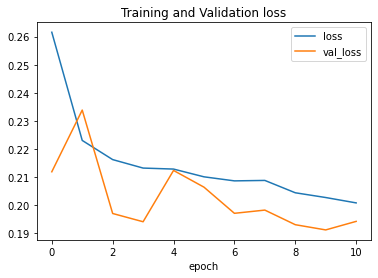

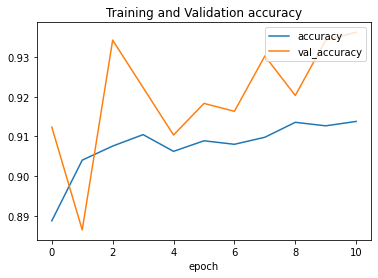

In [33]:
training_fig = plt.figure()
training_ax = training_fig.add_subplot(111)
training_ax.plot(history.history['loss'])
training_ax.plot(history.history['accuracy'])
training_ax.set_title('Training loss and accuracy')
training_ax.set_xlabel('epoch')
training_ax.legend(['loss', 'accuracy'], loc='upper right')

validation_fig = plt.figure()
validation_ax = validation_fig.add_subplot(111)
validation_ax.plot(history.history['val_loss'])
validation_ax.plot(history.history['val_accuracy'])
validation_ax.set_title('Validation loss and accuracy')
validation_ax.set_xlabel('epoch')
validation_ax.legend(['val_loss', 'val_accuracy'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['loss'])
tarin_val_loss_ax.plot(history.history['val_loss'])
tarin_val_loss_ax.set_title('Training and Validation loss')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['loss', 'val_loss'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['accuracy'])
tarin_val_loss_ax.plot(history.history['val_accuracy'])
tarin_val_loss_ax.set_title('Training and Validation accuracy')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')


plt.show()

In [34]:
h_train,h_test = predict(X_trainS,X_testS)

In [35]:
# cf_train = confusion_matrix(y_trainS, h_train)
# ca_train = np.mean(accuracy_score(y_trainS, h_train))
# ps_train = np.mean(precision_score(y_trainS, h_train, average=None)) 
# rs_train = np.mean(recall_score(y_trainS, h_train, average=None))
# f1_train = np.mean(f1_score(y_trainS, h_train, average=None))

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)


print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test = confusion_matrix(y_testS, h_test)
ca_test = np.mean(accuracy_score(y_testS, h_test))
ps_test = np.mean(precision_score(y_testS, h_test, average=None))
rs_test = np.mean(recall_score(y_testS, h_test, average=None))
f1_test = np.mean(f1_score(y_testS, h_test, average=None))
print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SNN_TfidfVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4255   80]
 [ 289  390]]
Average Train Accuracy: 92.64%
Average Train Precision 88.31%
Average Train Recall: 77.80%
Average Train F1: 81.86%
Training Performance
Average Test Confusion Matrix:
 [[485   5]
 [ 27  41]]
Average Test Accuracy: 94.27%
Average Test Precision 91.93%
Average Test Recall 79.64%
Average Test F1: 84.37%


#Input : Deep Neural Network (DNN) 

In [36]:

K.clear_session()
start = time.time()


early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_DNN_model(X_trainS.shape[1],0.1)


history =model.fit(X_trainS,
                   y_trainS,
                   epochs=num_epochs,
                   verbose=1,
                   validation_split=0.1,
                   callbacks=callbacks_list)
print(f'Time: {time.time() - start}')

Train on 4512 samples, validate on 502 samples
Epoch 1/50
4512/4512 [==============================] - 3s 613us/step - loss: 0.3692 - accuracy: 0.8797 - val_loss: 0.3276 - val_accuracy: 0.8825
Epoch 2/50
4512/4512 [==============================] - 2s 402us/step - loss: 0.2845 - accuracy: 0.9054 - val_loss: 0.2483 - val_accuracy: 0.9064
Epoch 3/50
4512/4512 [==============================] - 2s 409us/step - loss: 0.2577 - accuracy: 0.9102 - val_loss: 0.2076 - val_accuracy: 0.9243
Epoch 4/50
4512/4512 [==============================] - 2s 439us/step - loss: 0.2577 - accuracy: 0.9076 - val_loss: 0.2052 - val_accuracy: 0.9263
Epoch 5/50
4512/4512 [==============================] - 2s 415us/step - loss: 0.2570 - accuracy: 0.9136 - val_loss: 0.2115 - val_accuracy: 0.9183
Epoch 6/50
4512/4512 [==============================] - 2s 404us/step - loss: 0.2411 - accuracy: 0.9189 - val_loss: 0.2088 - val_accuracy: 0.9303
Epoch 7/50
4512/4512 [==============================] - 2s 406us/step - loss:

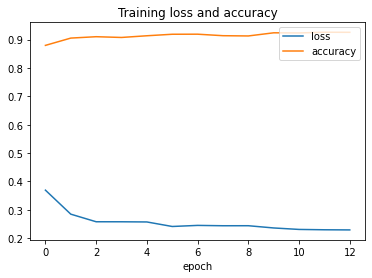

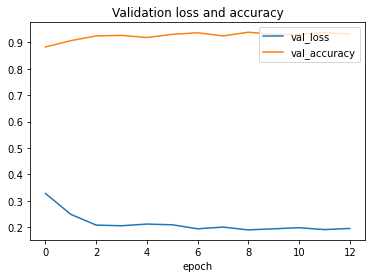

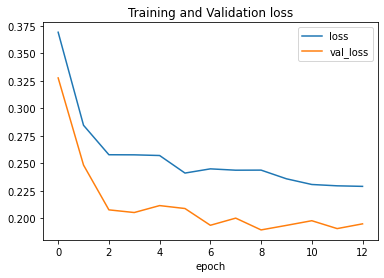

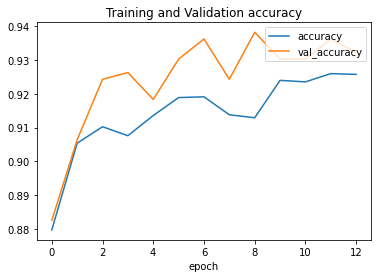

In [37]:
training_fig = plt.figure()
training_ax = training_fig.add_subplot(111)
training_ax.plot(history.history['loss'])
training_ax.plot(history.history['accuracy'])
training_ax.set_title('Training loss and accuracy')
training_ax.set_xlabel('epoch')
training_ax.legend(['loss', 'accuracy'], loc='upper right')

validation_fig = plt.figure()
validation_ax = validation_fig.add_subplot(111)
validation_ax.plot(history.history['val_loss'])
validation_ax.plot(history.history['val_accuracy'])
validation_ax.set_title('Validation loss and accuracy')
validation_ax.set_xlabel('epoch')
validation_ax.legend(['val_loss', 'val_accuracy'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['loss'])
tarin_val_loss_ax.plot(history.history['val_loss'])
tarin_val_loss_ax.set_title('Training and Validation loss')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['loss', 'val_loss'], loc='upper right')

tarin_val_loss_fig = plt.figure()
tarin_val_loss_ax = tarin_val_loss_fig.add_subplot(111)
tarin_val_loss_ax.plot(history.history['accuracy'])
tarin_val_loss_ax.plot(history.history['val_accuracy'])
tarin_val_loss_ax.set_title('Training and Validation accuracy')
tarin_val_loss_ax.set_xlabel('epoch')
tarin_val_loss_ax.legend(['accuracy', 'val_accuracy'], loc='upper right')


plt.show()

In [38]:
h_train,h_test=predict(X_trainS,X_testS)

In [39]:
# cf_train = confusion_matrix(y_trainS, h_train)
# ca_train = np.mean(accuracy_score(y_trainS, h_train))
# ps_train = np.mean(precision_score(y_trainS, h_train, average=None)) 
# rs_train = np.mean(recall_score(y_trainS, h_train, average=None))
# f1_train = np.mean(f1_score(y_trainS, h_train, average=None))

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,h_train)


print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)

# cf_test = confusion_matrix(y_testS, h_test)
# ca_test = np.mean(accuracy_score(y_testS, h_test))
# ps_test = np.mean(precision_score(y_testS, h_test, average=None))
# rs_test = np.mean(recall_score(y_testS, h_test, average=None))
# f1_test = np.mean(f1_score(y_testS, h_test, average=None))

print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("DNN_TfidfVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4286   49]
 [ 245  434]]
Average Train Accuracy: 94.14%
Average Train Precision 92.22%
Average Train Recall: 81.39%
Average Train F1: 85.69%
Training Performance
Average Test Confusion Matrix:
 [[484   6]
 [ 27  41]]
Average Test Accuracy: 94.09%
Average Test Precision 90.98%
Average Test Recall 79.53%
Average Test F1: 84.00%


In [40]:
dt = DecisionTreeClassifier(random_state=50)
dt.fit(X_trainS, y_trainS)

DecisionTreeClassifier(random_state=50)

In [41]:
dt_p_train = dt.predict(X_trainS)
print(dt_p_train.shape,y_testS.shape)

(5014,) (558,)


In [42]:
cm = confusion_matrix(y_trainS, dt_p_train)

print(cm)

[[4326    9]
 [ 132  547]]


In [43]:
target_names = ['ham', 'spam']
print ("Accuracy :: {0:0.2%} \n\n" .format(accuracy_score(y_testS, dt.predict(X_testS))))
print (classification_report(y_testS, dt.predict(X_testS),target_names=target_names))

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainS,dt_p_train)
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testS,h_test)


pred_scores.append(("DecisionTreeClassifier_TfidfVectorizer",f1_test))

Accuracy :: 94.62% 


              precision    recall  f1-score   support

         ham       0.96      0.98      0.97       490
        spam       0.81      0.74      0.77        68

    accuracy                           0.95       558
   macro avg       0.89      0.86      0.87       558
weighted avg       0.94      0.95      0.95       558

Average Train Confusion Matrix:
 [[4326    9]
 [ 132  547]]
Average Train Accuracy: 97.19%
Average Train Precision 97.71%
Average Train Recall: 90.18%
Average Train F1: 93.49%


## NLTK exploration:

In [44]:
XCV = X_train['sms']
ycv = X_train['label']

In [45]:

X_trainCV, X_testCV, y_trainCV, y_testCV = train_test_split(XCV, 
                                                    ycv,test_size=0.10, shuffle=True,
                                                    random_state=1)
# X_trains, X_val, y_trains, y_val = train_test_split(X_train, 
#                                                     y_train,test_size=0.20, shuffle=False,
#                                                     random_state=1)

unique, counts = np.unique(y_testCV, return_counts=True)
dict(zip(unique, counts))

{0: 490, 1: 68}

In [46]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_trainCV)

# validation_data = count_vector.transform(X_val)

#count_vector.get_feature_names()
# Transform testing data and return the matrix. 
testing_data = count_vector.transform(X_testCV)


In [47]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_trainCV)

MultinomialNB()

In [48]:
predictions = naive_bayes.predict(testing_data)


In [49]:
print(y_testCV.shape,predictions.shape)

(558,) (558,)


In [50]:

print('Accuracy score: {0:0.2%}'.format(accuracy_score(y_testCV, predictions)))
print('Precision score: {0:0.2%}'.format(precision_score(y_testCV, predictions)))
print('Recall score: {0:0.2%}'.format(recall_score(y_testCV, predictions)))
print('F1 score: {0:0.2%}'.format(f1_score(y_testCV, predictions)))

#cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_testCV,predictions)
cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,predictions)
pred_scores.append(("MultiNB_CountVectorizer",f1_test))

Accuracy score: 98.39%
Precision score: 94.03%
Recall score: 92.65%
F1 score: 93.33%


In [51]:
model_SGDClassifier = SGDClassifier(eta0=0.1, max_iter=1000, tol=0.1, random_state=1, loss='log')#, penalty="l2")
model_SGDClassifier.fit(training_data, y_trainCV.squeeze())

SGDClassifier(eta0=0.1, loss='log', random_state=1, tol=0.1)

In [52]:
h_train = model_SGDClassifier.predict(training_data)
# h_val = model_SGDClassifier.predict(validation_data)
h_test = model_SGDClassifier.predict(testing_data)
print("Prediction: ",h_train)



Prediction:  [0 0 0 ... 0 0 0]


In [53]:
##Validation matirx
cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)


print(">>>>>>>>>>Training Performance<<<<<<<<<<")
print("Train Confusion Matrix:\n", cf_train)
print("Train Accuracy: {0:0.2%}".format(ca_train))
print("Train Precision {0:0.2%}".format(ps_train))
print("Train Recall: {0:0.2%}".format(rs_train))
print("Train F1: {0:0.2%}".format(f1_train))


>>>>>>>>>>Training Performance<<<<<<<<<<
Train Confusion Matrix:
 [[4333    2]
 [   4  675]]
Train Accuracy: 99.88%
Train Precision 99.81%
Train Recall: 99.68%
Train F1: 99.74%


In [54]:
cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,h_test)

print("\n>>>>>>>>>>Test Performance<<<<<<<<<<")
print("Test Confusion Matrix:\n", cf_test)
print("Test Accuracy: {0:0.2%}".format(ca_test))
print("Test Precision {0:0.2%}".format(ps_test))
print("Test Recall {0:0.2%}".format(rs_test))
print("Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SGDClassifier_CountVectorizer",f1_test))


>>>>>>>>>>Test Performance<<<<<<<<<<
Test Confusion Matrix:
 [[490   0]
 [  5  63]]
Test Accuracy: 99.10%
Test Precision 99.49%
Test Recall 96.32%
Test F1: 97.84%


In [55]:
start = time.time()
model = SGDClassifier(tol=0.1, random_state=1, loss='log')
param_grid = [
                {'learning_rate': ['invscaling', 'adaptive'],
                 'eta0': [0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
                 'max_iter': [1000, 2000, 3000, 4000, 5000], 
                }
]

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1', refit=True)
grid_search.fit(training_data, y_trainCV.squeeze())
print(grid_search.best_params_)
# grid_search.best_params_ :{'eta0': 0.3, 'learning_rate': 'adaptive', 'max_iter': 100}
print(f'Time: {time.time() - start}')

{'eta0': 0.4, 'learning_rate': 'adaptive', 'max_iter': 1000}
Time: 18.419409036636353


In [56]:
best_model = grid_search.best_estimator_

h_train = best_model.predict(training_data)
h_test = best_model.predict(testing_data)

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)


cf,ca,ps,rs,f1=matrix(y_testCV,h_test)

print(">>>>>>>>>> Test Performance <<<<<<<<<")
print("Accuracy: {0:0.2%}".format(ca))
print("Confusion Matrix:\n", cf)
print("Precision: {0:0.2%}".format(ps))
print("Recall:    {0:0.2%}".format(rs))
print("F1:        {0:0.2%}".format(f1))
pred_scores.append(("SGDClassifier_GS_CountVectorizer",f1))

>>>>>>>>>> Test Performance <<<<<<<<<
Accuracy: 98.75%
Confusion Matrix:
 [[490   0]
 [  7  61]]
Precision: 99.30%
Recall:    94.85%
F1:        96.93%


In [57]:
num_epochs = 50

start = time.time()
early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_SNN_model(training_data.shape[1],0.1)
history = model.fit(training_data,
                   y_trainCV,
                   epochs=num_epochs,
                   verbose=1,
                   validation_split=0.1,
                   callbacks=callbacks_list)
history_dict = history.history
history_dict.keys()
print(f'Time: {time.time() - start}')

Train on 4512 samples, validate on 502 samples
Epoch 1/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.1455 - accuracy: 0.9510 - val_loss: 0.0775 - val_accuracy: 0.9741
Epoch 2/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0374 - accuracy: 0.9894 - val_loss: 0.0753 - val_accuracy: 0.9741
Epoch 3/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0128 - accuracy: 0.9969 - val_loss: 0.0613 - val_accuracy: 0.9781
Epoch 4/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0735 - val_accuracy: 0.9761
Epoch 5/50
4512/4512 [==============================] - 10s 2ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0674 - val_accuracy: 0.9821
Epoch 6/50
4512/4512 [==============================] - 10s 2ms/step - loss: 9.1522e-04 - accuracy: 1.0000 - val_loss: 0.0710 - val_accuracy: 0.9841
Epoch 7/50
4512/4512 [==============================] - 10s 2ms/step - loss: 6.

In [58]:
h_train,h_test=predict(training_data,testing_data)

In [59]:
cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)



print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,h_test)

print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("SNN_CountVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4332    3]
 [   5  674]]
Average Train Accuracy: 99.84%
Average Train Precision 99.72%
Average Train Recall: 99.60%
Average Train F1: 99.66%
Training Performance
Average Test Confusion Matrix:
 [[490   0]
 [  6  62]]
Average Test Accuracy: 98.92%
Average Test Precision 99.40%
Average Test Recall 95.59%
Average Test F1: 97.39%


In [60]:
K.clear_session()

start = time.time()

early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0.1,patience=10) 
callbacks_list = [early_stopping]

model = build_DNN_model(training_data.shape[1],0.1)


history =model.fit(training_data,
                   y_trainCV,
                   epochs=num_epochs,
                   verbose=1,
                   validation_split=0.1,
                   callbacks=callbacks_list)
print(f'Time: {time.time() - start}')

Train on 4512 samples, validate on 502 samples
Epoch 1/50
4512/4512 [==============================] - 16s 3ms/step - loss: 0.2921 - accuracy: 0.9317 - val_loss: 0.1791 - val_accuracy: 0.9562
Epoch 2/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.1694 - accuracy: 0.9694 - val_loss: 0.0951 - val_accuracy: 0.9821
Epoch 3/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.1389 - accuracy: 0.9741 - val_loss: 0.0881 - val_accuracy: 0.9861
Epoch 4/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.1184 - accuracy: 0.9818 - val_loss: 0.0904 - val_accuracy: 0.9841
Epoch 5/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.1069 - accuracy: 0.9787 - val_loss: 0.0827 - val_accuracy: 0.9821
Epoch 6/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.1022 - accuracy: 0.9809 - val_loss: 0.0799 - val_accuracy: 0.9841
Epoch 7/50
4512/4512 [==============================] - 15s 3ms/step - loss: 0.0925

In [61]:
h_train,h_test=predict(training_data,testing_data)

In [62]:


cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,h_train)


print("Training Performance")
print("Average Train Confusion Matrix:\n", cf_train)
print("Average Train Accuracy: {0:0.2%}".format(ca_train))
print("Average Train Precision {0:0.2%}".format(ps_train))
print("Average Train Recall: {0:0.2%}".format(rs_train))
print("Average Train F1: {0:0.2%}".format(f1_train))

cf_test,ca_test,ps_test,rs_test,f1_test=matrix(y_testCV,h_test)

print("Training Performance")
print("Average Test Confusion Matrix:\n", cf_test)
print("Average Test Accuracy: {0:0.2%}".format(ca_test))
print("Average Test Precision {0:0.2%}".format(ps_test))
print("Average Test Recall {0:0.2%}".format(rs_test))
print("Average Test F1: {0:0.2%}".format(f1_test))

pred_scores.append(("DNN_CountVectorizer",f1_test))

Training Performance
Average Train Confusion Matrix:
 [[4329    6]
 [  10  669]]
Average Train Accuracy: 99.68%
Average Train Precision 99.44%
Average Train Recall: 99.19%
Average Train F1: 99.32%
Training Performance
Average Test Confusion Matrix:
 [[490   0]
 [  9  59]]
Average Test Accuracy: 98.39%
Average Test Precision 99.10%
Average Test Recall 93.38%
Average Test F1: 96.00%


In [63]:
dt = DecisionTreeClassifier(random_state=50)
dt.fit(training_data, y_trainCV)

DecisionTreeClassifier(random_state=50)

In [64]:
dt_p_train = dt.predict(training_data)
print(dt_p_train.shape,testing_data.shape)

(5014,) (558, 8882)


In [65]:
cm = confusion_matrix(y_trainCV, dt_p_train)

print(cm)

[[4335    0]
 [   0  679]]


In [66]:

target_names = ['ham', 'spam']
print ("Accuracy :: {0:0.2%} \n\n" .format(accuracy_score(y_testCV, dt.predict(testing_data))))
print (classification_report(y_testS, dt.predict(testing_data),target_names=target_names))

cf_train,ca_train,ps_train,rs_train,f1_train=matrix(y_trainCV,dt_p_train)
# pred_scores.append(("DecisionTreeClassifier_CountVectorizer",f1_train))

Accuracy :: 96.95% 


              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       490
        spam       0.92      0.82      0.87        68

    accuracy                           0.97       558
   macro avg       0.95      0.91      0.93       558
weighted avg       0.97      0.97      0.97       558



In [67]:
pred_scores

[('SGDClassifier_TfidfVectorizer', 0.7027027027027027),
 ('SGDClassifier_GS_TfidfVectorizer', 0.6861313868613138),
 ('SNN_TfidfVectorizer', 0.843681058934762),
 ('DNN_TfidfVectorizer', 0.8400382226469183),
 ('DecisionTreeClassifier_TfidfVectorizer', 0.8400382226469183),
 ('MultiNB_CountVectorizer', 0.962079510703364),
 ('SGDClassifier_CountVectorizer', 0.9783779594683613),
 ('SGDClassifier_GS_CountVectorizer', 0.9693221177634834),
 ('SNN_CountVectorizer', 0.9738804805741925),
 ('DNN_CountVectorizer', 0.960016878577741)]

In [68]:
df = pd.DataFrame(pred_scores) 

df

,0,1
0,SGDClassifier_TfidfVectorizer,0.702703
1,SGDClassifier_GS_TfidfVectorizer,0.686131
2,SNN_TfidfVectorizer,0.843681
3,DNN_TfidfVectorizer,0.840038
4,DecisionTreeClassifier_TfidfVectorizer,0.840038
5,MultiNB_CountVectorizer,0.962080
6,SGDClassifier_CountVectorizer,0.978378
7,SGDClassifier_GS_CountVectorizer,0.969322
8,SNN_CountVectorizer,0.973880
9,DNN_CountVectorizer,0.960017


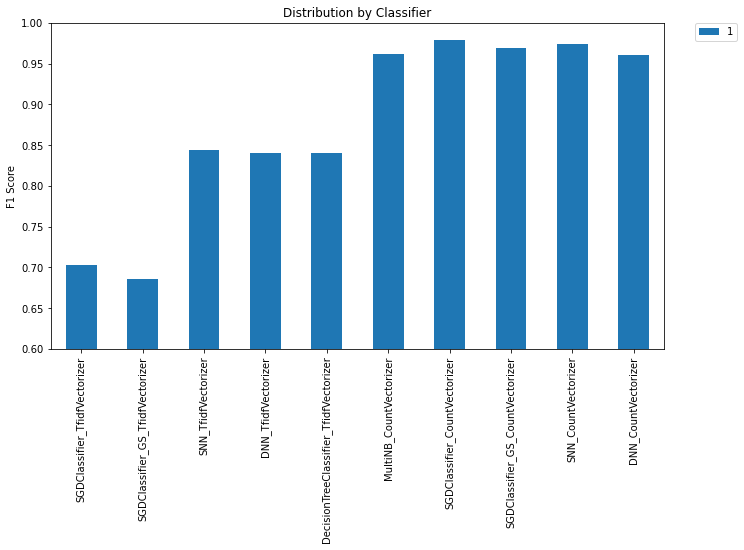

In [69]:
df.plot(kind='bar', ylim=(0.6,1.0), figsize=(11,6), align='center')
plt.xticks(np.arange(10), df[0])
plt.ylabel('F1 Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

